# Computing Nuclear Reaction Rates

Melanie A. Zaidel

This notebook contains a short tutorial on computing the $^8$B neutrino production zone as predicted by the reference solar model and non-resonant nuclear reactions. For more information about nuclear fusion and stellar structure more broadly, see the GitHub repository at https://github.com/melanieAzaidel/HowDoStarsShine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from astropy import constants as const
from astropy import units as u
import scipy as sp

Set some plotting parameters. Running the next cell for the first time may take a few minutes.

Note: if your machine does not have some LaTeX/MiKTeX distribution installed (or your Anaconda distribution can't find it), attempting to use the style sheet <code>style_prof2.mplstyle</code> may fail. You may need to add LaTeX/MiKTeX to your system PATH variable.

In [2]:
cm = plt.get_cmap('jet')
plt.style.use('style_prof2.mplstyle')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

default_size = 18
plt.rcParams.update({
    'font.size': default_size,  # This sets the default font size for everything
    'font.weight': 'bold',
    'axes.titlesize': default_size,
    'axes.labelsize': default_size,
    'xtick.labelsize': default_size,
    'ytick.labelsize': default_size,
    'legend.fontsize': default_size,
    'figure.titlesize': default_size,
    'axes.labelweight': 'bold',
    'text.usetex': True,
})

figsize = 5

plt.rcParams.update({
    'axes.linewidth': 1.5,       # Set frame (spine) thickness
    'xtick.major.width': 1.5,    # Set x-axis major tick thickness
    'ytick.major.width': 1.5,    # Set y-axis major tick thickness
    'xtick.minor.width': 1,  # Set x-axis minor tick thickness
    'ytick.minor.width': 1,  # Set y-axis minor tick thickness
    'xtick.major.size': 8,     # Set x-axis major tick length
    'ytick.major.size': 8,     # Set y-axis major tick length
    'xtick.minor.size': 3,     # Set x-axis minor tick length
    'ytick.minor.size': 3,     # Set y-axis minor tick length
})


matplotlib.rcParams['figure.figsize'] = [figsize,figsize]
matplotlib.rcParams['figure.subplot.left'] = 0
matplotlib.rcParams['figure.subplot.bottom'] = 0
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 1

dpi = 350

Let's start by getting the reference solar model from file, along with some variable profiles. For some reason, an issue arises when trying to package all variable profiles into a single .csv file. Some precision is lost, which makes a difference for some calculations. Notably, the mass fraction of $ ^7$Be is smooth when it's in a file on its own, but is jagged when placed in a combined file with all other variables. This is important for calculating the local rate of $ ^8$B neutrino production. This issue seems to be limited to some of the mass fractions.

The imprecision doesn't seem to impact any calculations in the paper. I'm not sure what's going on with some of the mass fractions, so I'll refer to the individual profiles awkwardly in this Notebook.

In [3]:
filepath = 'data/Individual Variable Profiles/'

SSM_r = np.array(pd.read_csv(filepath+'X_7Be.csv',names=['r','q'],skiprows=1,index_col=False)['r'])
SSM_T = np.array(pd.read_csv(filepath+'T.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_rho = np.array(pd.read_csv(filepath+'rho.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_P = np.array(pd.read_csv(filepath+'P.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_H = np.array(pd.read_csv(filepath+'X_H.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_He4 = np.array(pd.read_csv(filepath+'X_He4.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_He3 = np.array(pd.read_csv(filepath+'X_He3.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_C12 = np.array(pd.read_csv(filepath+'X_C12.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_N14 = np.array(pd.read_csv(filepath+'X_N14.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_O16 = np.array(pd.read_csv(filepath+'X_N16.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_7Be = np.array(pd.read_csv(filepath+'X_7Be.csv',names=['r','q'],skiprows=1,index_col=False)['q'])

Next, obtain the astrophysical S factors from Table I of https://arxiv.org/abs/2405.06470.

In [4]:
S17 = 2.05e-5 * u.MeV * u.barn
S17_prime = 0 * u.barn
S17_dbl_prime = 0 * u.barn* u.eV**(-1)

In [11]:
def T_6(T):
    return T/1e6

def tau(T,Z1,Z2,A):
    return 42.487 * (Z1**2 * Z2**2 * A * T_6(T)**-1)**(1/3)

def E0(T,Z1,Z2,A):
    return 1.2204 * (Z1**2 * Z2**2 * A * T_6(T)**2) **(1/3) * u.keV

def S_eff(T,S,Sp,Spp,Z1,Z2,A):
    E_0 = E0(T,Z1,Z2,A)
    term1 = (1 + 5/(12*tau(T,Z1,Z2,A)))
    #print(term1.unit)
    term2 = Sp*(E_0 + 35/36 * const.k_B * T * u.K)/S
    #print(term2.unit)
    term3 = Spp*E_0/S * (E_0/2 + 89/72 * const.k_B*T*u.K)
    #print(term3.unit)
    sum_of_terms = S*(term1 + term2 + term3)
    unitful_sum = sum_of_terms.to('keV barn')
    return (unitful_sum).value

def varphi(reactant1, reactant2, Z1, A1, Z2, A2):
    projectile = reactant1*Z1**2 /A1 + reactant1*Z1/A1
    target = reactant2*Z2**2 /A2 + reactant2*Z2/A2
    return np.sqrt(projectile + target)

def f_0(reactant1, reactant2, Z1, A1, Z2, A2,T,rho):
    return np.exp(0.188 * Z1*Z2 * varphi(reactant1, reactant2, Z1, A1, Z2, A2) * rho**(1/2) * T_6(T)**(-3/2))

def sigma_v(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp):
    A = (A1*A2)/(A1 + A2)
    screening = f_0(reactant1, reactant2, Z1, A1, Z2, A2,SSM_T,SSM_rho)
    s_factor = S_eff(SSM_T,S,Sp,Spp,Z1,Z2,A)

    return 1.3005e-15 * (Z1*Z2/(A*T_6(SSM_T)**2))**(1/3) * screening * s_factor * np.exp(-tau(SSM_T,Z1,Z2,A)) * u.cm**(3) * u.s**(-1)

def reactionRate(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp,m1,m2):
    n1 = SSM_rho*u.g*u.cm**(-3) * reactant1 / m1
    n2 = SSM_rho*u.g*u.cm**(-3) * reactant2 / m2
    if reactant1[0] == reactant2[0]:
        correction = 1/2
    else:
        correction = 1
    return n1 * n2 * correction * sigma_v(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp)

In [12]:
SSM_radius_cm = 6.9598e10*SSM_r

In [13]:
def plotReaction(x,y,x_label,y_label,normalization,title):
    y_norm = sp.integrate.simpson(4*np.pi*x**2 * y, x)
    fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
    ax.plot(x,4*np.pi* x**2 * y/y_norm,lw=1.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xlim(0,0.2)
    ax.set_ylim(0,20)
    ax.tick_params(axis='both', pad=6)
    plt.tight_layout()
    plt.show()

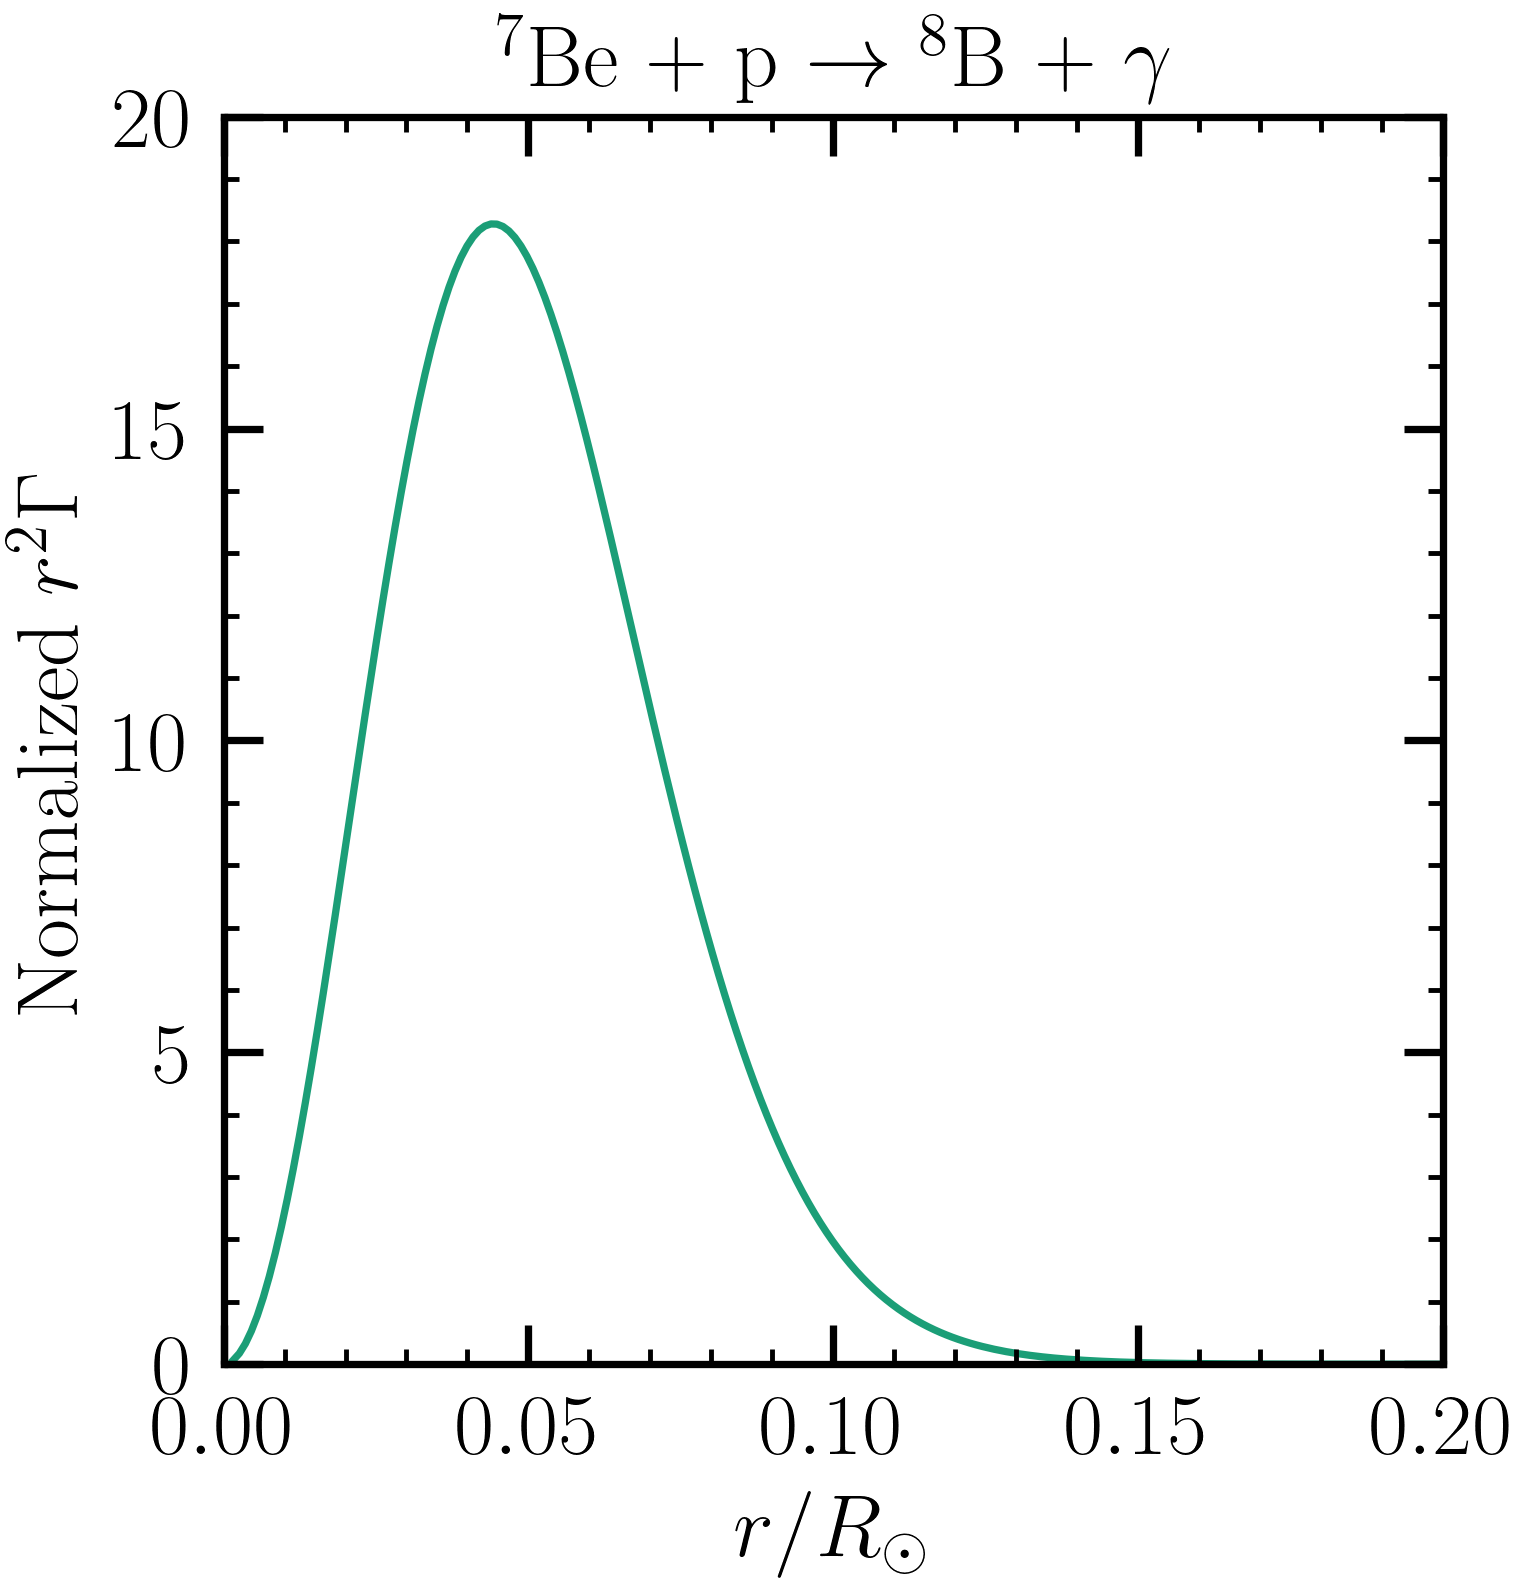

In [14]:
Z_H = 1 #Atomic number of Hydrogen
Z_Be7 = 4 #Atomic number of Beryllium
A_H = 1 #Mass number of Hydrogen
A_Be7 = 7 #Mass number of Beryllium
m_H = 1.6738e-24 * u.g #Mass of the Hydrogen atom
m_Be7 = 1.165e-23 * u.g #Mass of the Beryllium-7 atom

Be7p = reactionRate(SSM_H, SSM_7Be, Z_H, Z_Be7, A_H, A_Be7, S17,S17_prime,S17_dbl_prime,m_H,m_Be7)

title = r'$^{7}$Be + p $\rightarrow$ $^{8}$B + $\gamma$'

plotReaction(SSM_r,Be7p,r'$r/R_\odot$',r'Normalized $r^2 \Gamma$',24,title)